In [ ]:
# Download data
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'andrewmvd/medical-mnist'
!unzip -q medical-mnist.zip -d data
!rm medical-mnist.zip

In [ ]:
# Installations
!pip install pytorch-lightning
!pip install torchvision

In [3]:
# Imports
from torchvision.datasets import ImageFolder
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torchvision import transforms
from torch.utils.data import DataLoader

In [6]:
# Data preparation

class MedicalMNIST(pl.LightningDataModule):
    def __init__(self):
      super().__init__()
      self.labels_map = {0 : "AbdomenCT",
                         1 : "BreastMRI",
                         2 : "CXR",
                         3 : "ChestCT",
                         4 : "Hand",
                         5 : "HeadCT"}
      self.transform = transforms.Compose([transforms.ColorJitter(hue=.20, saturation=.20),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.RandomVerticalFlip(),
                                           transforms.RandomRotation(10),
                                           transforms.ToTensor()])
      # self.train_dims = None
      # self.vocab_size = 0

    def prepare_data(self):
      # called only on 1 GPU
      self.dataset = ImageFolder("./data/", transform=self.transform)

    def setup(self):
      # called on every GPU
      # vocab = load_vocab()
      # self.vocab_size = len(vocab)
      test_size = int(0.1 * len(self.dataset))
      self.test_set = torch.utils.data.Subset(self.dataset, range(test_size))  # take 10% for test
      self.train_set = torch.utils.data.Subset(self.dataset, range(test_size, len(self.dataset))) # the last part for train
      val_size = int(0.2 * len(self.train_set))
      train_size = len(self.train_set) - val_size
      self.train_set, self.val_set = torch.utils.data.random_split(self.train_set,
                                                                  [train_size, val_size])

    def train_dataloader(self):
      return DataLoader(self.train_set, batch_size=64, shuffle=True)

    def val_dataloader(self):
      return DataLoader(self.val_set, batch_size=64, shuffle=True)

    def test_dataloader(self):
      return DataLoader(self.test_set, batch_size=64, shuffle=True)

    def visualize_dataset(self):
      # Visualizes dataset
      figure = plt.figure(figsize=(8, 8))
      cols, rows = 3, 3
      for i in range(1, cols * rows + 1):
          sample_idx = torch.randint(len(self.train_set), size=(1,)).item()
          img, label = self.train_set[sample_idx]
          figure.add_subplot(rows, cols, i)
          plt.title(self.labels_map[label])
          plt.axis("off")
          plt.imshow(img.permute(1, 2, 0))
      plt.show()

    def visualize_dataloader(self):
      # Display image and label
      train_dataloader = self.train_dataloader()
      train_features, train_labels = next(iter(train_dataloader))
      print(f"Feature batch shape: {train_features.size()}")
      print(f"Labels batch shape: {train_labels.size()}")
      img = train_features[0]
      label = train_labels[0]
      plt.imshow(img.permute(1, 2, 0))
      plt.show()
      print(f"Label: {self.labels_map[label.item()]}")

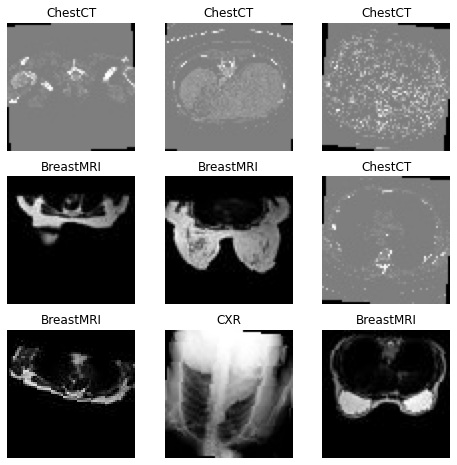

Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])


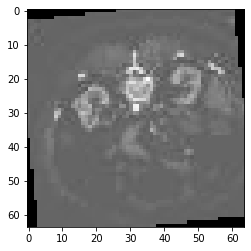

Label: AbdomenCT


In [7]:
dm = MedicalMNIST()
dm.prepare_data()
dm.setup()
dm.visualize_dataset()
dm.visualize_dataloader()